# 3D Sensing & Sensor Fusion  - 2nd assignment - Upsampling

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as SSIM, mean_squared_error as MSE
from numba import njit

## Subtask 1

- Implement the Bilateral or the Bilateral Median filter, your choice.
- Evaluate the filter on an image of your choice (see below).

### Bilateral filter

In [2]:
@njit
def bilateral_filter(image, window_size, sigma_d, sigma_r):
  height = image.shape[0]
  width = image.shape[1]
  half_window = window_size // 2
  filtered_image = np.zeros(image.shape, image.dtype)

  bgr_diff = lambda i, j, k, l: \
    np.sqrt(np.square(image[k,l,0] - image[i,j,0]) +
            np.square(image[k,l,1] - image[i,j,1]) +
            np.square(image[k,l,2] - image[i,j,2]))

  w = lambda i, j, k, l: np.exp(
    -((np.square(np.subtract(i,k)) + np.square(np.subtract(j,l))) / (2 * np.square(sigma_d)))
    -(bgr_diff(i, j, k, l) / (2 * np.square(sigma_r)))
  )

  for i in range(height):
    for j in range(width):
      sum_b = 0.
      sum_g = 0.
      sum_r = 0.
      sum_weight = 0.

      for k in range(-half_window, half_window+1):
        for l in range(-half_window, half_window+1):
          neighbor_i = i+k
          neighbor_j = j+l
          
          if neighbor_i < 0: neighbor_i = 0
          if neighbor_j < 0: neighbor_j = 0
          if neighbor_i >= height: neighbor_i = height-1
          if neighbor_j >= width: neighbor_j = width-1

          weight = w(i, j, neighbor_i, neighbor_j)
          sum_b += image[neighbor_i,neighbor_j,0] * weight
          sum_g += image[neighbor_i,neighbor_j,1] * weight
          sum_r += image[neighbor_i,neighbor_j,2] * weight
          sum_weight += weight

      filtered_image[i,j,0] = int(np.round(sum_b // sum_weight))
      filtered_image[i,j,1] = int(np.round(sum_g // sum_weight))
      filtered_image[i,j,2] = int(np.round(sum_r // sum_weight))

  return filtered_image

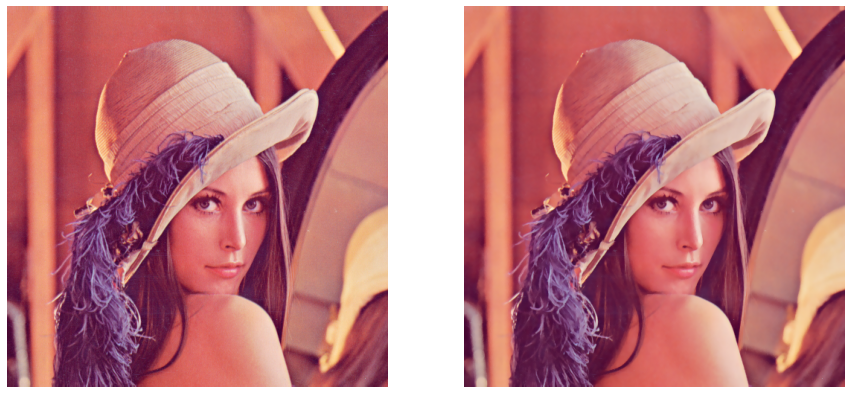

In [3]:
image = cv2.imread('lenna.png')
image_bilateral = bilateral_filter(image, window_size=5, sigma_d=3, sigma_r=3)

i = 0
plt.figure(figsize=(15, 8))
for image in [image, image_bilateral]:
  plt.subplot(1, 2, i+1)
  plt.axis('off')
  _ = plt.imshow(image[:,:,::-1])
  i += 1

### Evaluation

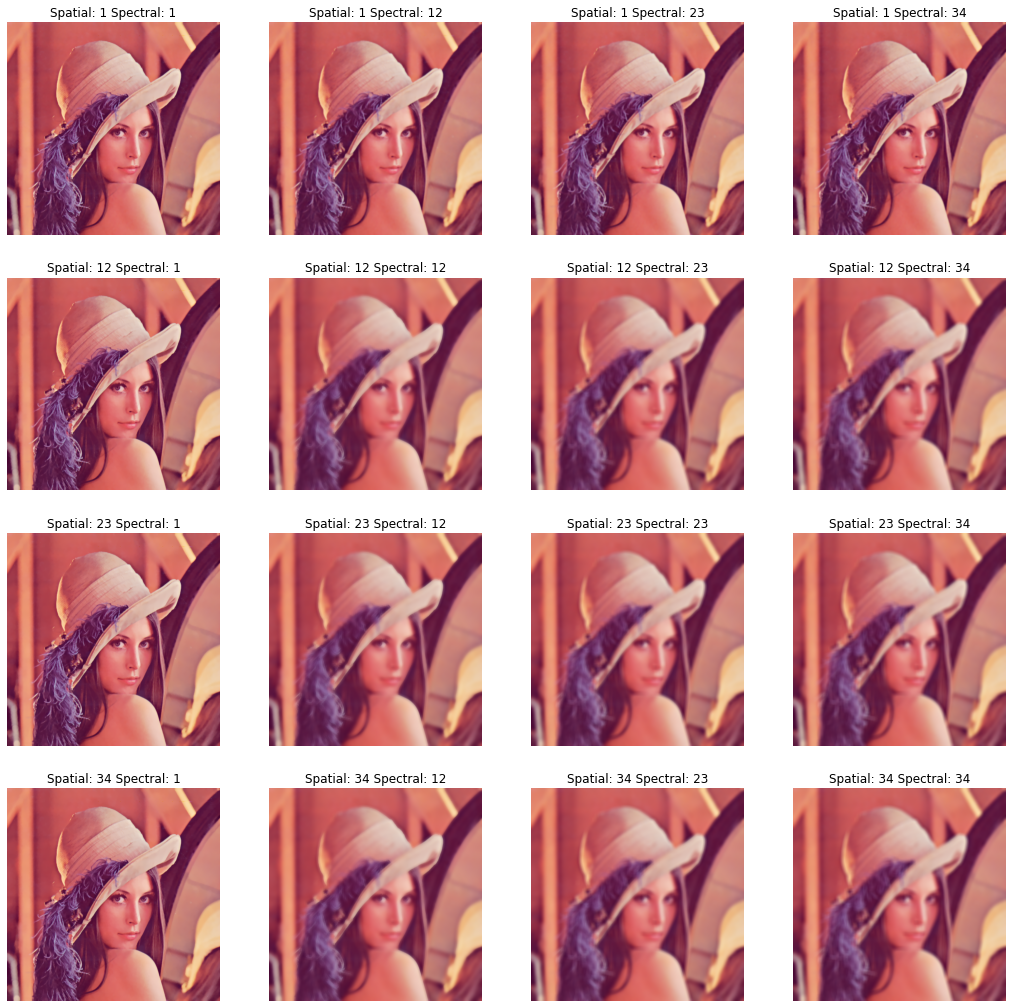

In [4]:
col = 0
plt.figure(figsize=(18,18))
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, col+1)
    sigma_d = i+1+(i*10)
    sigma_r = j+1+(j*10)

    plt.title(f'Spatial: {sigma_d} Spectral: {sigma_r}')
    img = bilateral_filter(image, window_size=11, sigma_d=sigma_d, sigma_r=sigma_r)
    plt.axis('off')
    _ = plt.imshow(img[:,:,::-1])
    col += 1

## Subtask 2

- Convert a bilateral filter to Guided Joint bilateral filter for guided image upsampling.
- Apply the filter to upsample a depth image, guided by an RGB image.

### Joint bilateral filter

In [5]:
@njit
def joint_bilateral_filter(image, guide, window_size, sigma_d, sigma_r):
  height = image.shape[0]
  width = image.shape[1]
  half_window = window_size // 2
  filtered_image = np.zeros(image.shape, image.dtype)

  bgr_diff = lambda i, j, k, l: \
    np.sqrt(np.square(guide[k,l,0] - guide[i,j,0]) +
            np.square(guide[k,l,1] - guide[i,j,1]) +
            np.square(guide[k,l,2] - guide[i,j,2]))

  w = lambda i, j, k, l: np.exp(
    -((np.square(np.subtract(i,k)) + np.square(np.subtract(j,l))) / (2 * np.square(sigma_d)))
    -((bgr_diff(i,j,k,l)) / (2 * np.square(sigma_r)))
  )

  for i in range(height):
    for j in range(width):
      sum = 0.
      sum_weight = 0.

      for k in range(-half_window, half_window+1):
        for l in range(-half_window, half_window+1):
          neighbor_i = i+k
          neighbor_j = j+l
          
          if neighbor_i < 0: neighbor_i = 0
          if neighbor_j < 0: neighbor_j = 0
          if neighbor_i >= height: neighbor_i = height-1
          if neighbor_j >= width: neighbor_j = width-1

          weight = w(i, j, neighbor_i, neighbor_j)
          sum += image[neighbor_i,neighbor_j] * weight
          sum_weight += weight

      filtered_image[i,j] = int(np.round(sum // sum_weight))

  return filtered_image

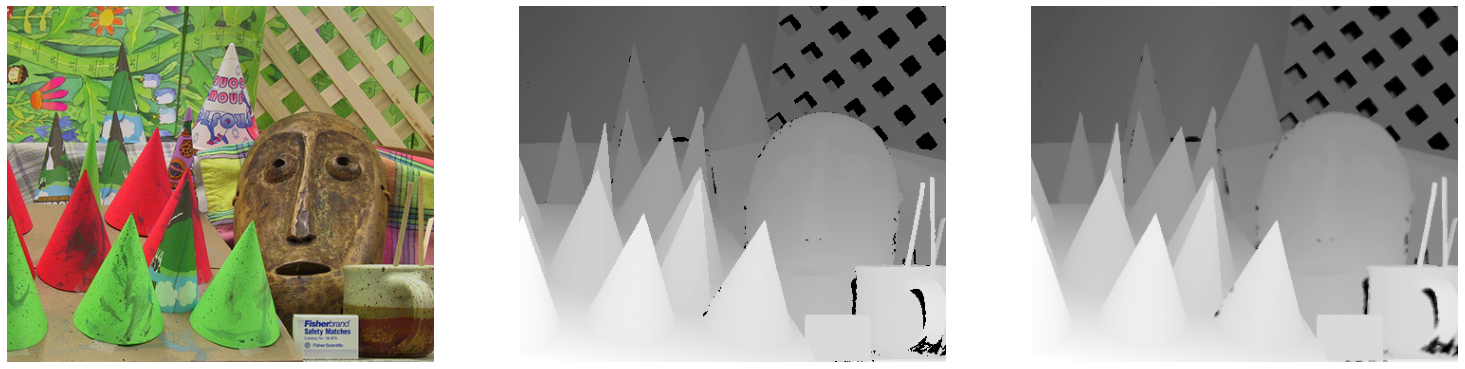

In [6]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path)

image_joint_bilateral = joint_bilateral_filter(image_depth, image_guide, window_size=5, sigma_d=3, sigma_r=3)

i = 0
plt.figure(figsize=(26, 18))
for image in [image_guide, image_depth, image_joint_bilateral]:
  plt.subplot(1, 3, i+1)
  plt.axis('off')
  if image.ndim == 2:
    _ = plt.imshow(image, cmap='gray')
  else:
    _ = plt.imshow(image[:,:,::-1])
  i += 1

### Upsampling

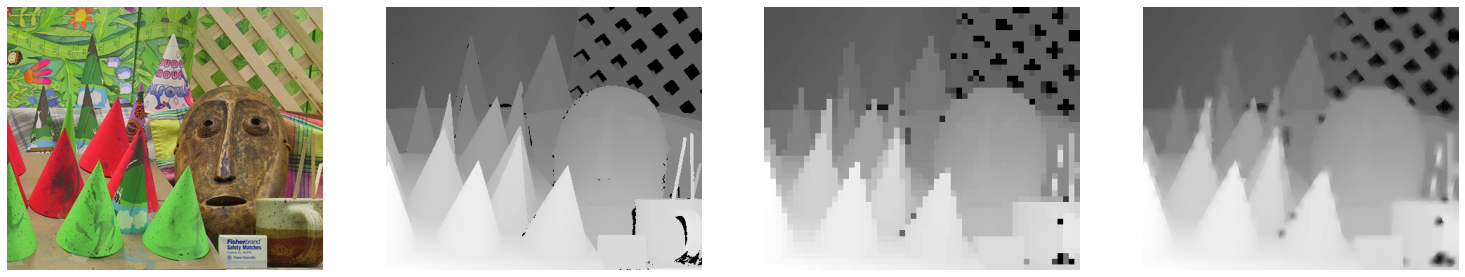

In [7]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path)

factor = 8

image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // factor, image_depth.shape[0] // factor))
image_depth_resized = cv2.resize(image_depth_resized, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_NEAREST)

image_joint_bilateral = joint_bilateral_filter(image_depth_resized, image_guide, window_size=11, sigma_d=6, sigma_r=4)

i = 0
plt.figure(figsize=(26, 18))
for image in [image_guide, image_depth, image_depth_resized, image_joint_bilateral]:
  plt.subplot(1, 4, i+1)
  plt.axis('off')
  if image.ndim == 2:
    _ = plt.imshow(image, cmap='gray')
  else:
    _ = plt.imshow(image[:,:,::-1])
  i += 1

### Iterative approach

In [8]:
def iterative_upsample(input_depth, input_guide, filter_params):
  factor = np.log2(input_guide.shape[0] // input_depth.shape[0])
  iter_depth = input_depth

  for _ in range(int(factor)):
    iter_depth = cv2.resize(iter_depth, (iter_depth.shape[1] * 2, iter_depth.shape[0] * 2), interpolation=cv2.INTER_NEAREST)
    iter_guide = cv2.resize(input_guide, (iter_depth.shape[1], iter_depth.shape[0]))
    iter_depth = joint_bilateral_filter(iter_depth, iter_guide, **filter_params)

  iter_depth = cv2.resize(iter_depth, (input_guide.shape[1], input_guide.shape[0]), interpolation=cv2.INTER_NEAREST)
  return joint_bilateral_filter(iter_depth, input_guide, **filter_params)


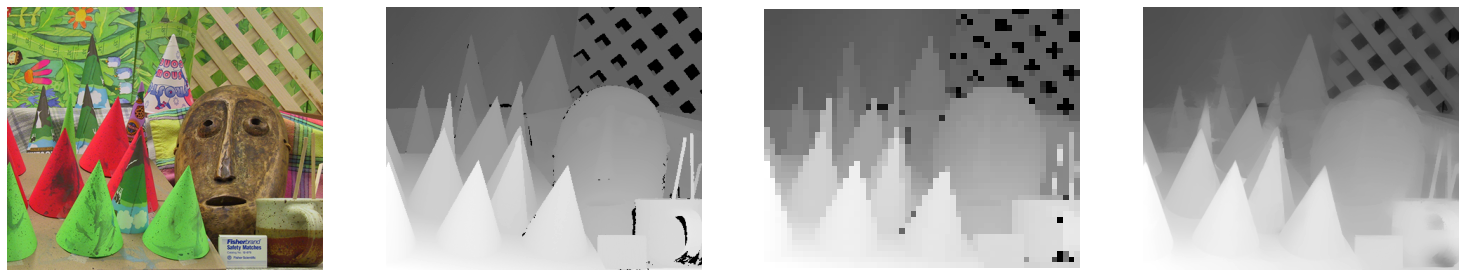

In [9]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path)

factor = 8

filter_params = dict(window_size=11, sigma_d=4, sigma_r=3)
image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // factor, image_depth.shape[0] // factor))
iter_result = iterative_upsample(image_depth_resized, image_guide, filter_params)

i = 0
plt.figure(figsize=(26, 18))
for image in [image_guide, image_depth, image_depth_resized, iter_result]:
  plt.subplot(1, 4, i+1)
  plt.axis('off')
  if image.ndim == 2:
    _ = plt.imshow(image, cmap='gray')
  else:
    _ = plt.imshow(image[:,:,::-1])
  i += 1

## Subtask 3

### Utilities

In [10]:
def upsample_eval_simple(dataset, factor, params, withNoise=True):
  image_depth = cv2.imread(f'datasets/{dataset}/disp.png', cv2.IMREAD_GRAYSCALE)
  image_guide = cv2.imread(f'datasets/{dataset}/im.png')

  if withNoise:
    noise = np.zeros(image_depth.shape, image_depth.dtype)
    mean = 0
    stddev = 7.5
    cv2.randn(noise, mean, stddev)
    image_depth += noise

  image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // factor, image_depth.shape[0] // factor))
  image_depth_resized = cv2.resize(image_depth_resized, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_NEAREST)

  return [image_depth, image_guide, image_depth_resized, joint_bilateral_filter(image_depth_resized, image_guide, **params)]

def upsample_eval_iterative(dataset, factor, params, withNoise=True):
  image_depth = cv2.imread(f'datasets/{dataset}/disp.png', cv2.IMREAD_GRAYSCALE)
  image_guide = cv2.imread(f'datasets/{dataset}/im.png')

  if withNoise:
    noise = np.zeros(image_depth.shape, image_depth.dtype)
    mean = 0
    stddev = 5
    cv2.randn(noise, mean, stddev)
    image_depth += noise

  image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // factor, image_depth.shape[0] // factor))

  return [image_depth, image_guide, image_depth_resized, iterative_upsample(image_depth_resized, image_guide, params)]

def get_resized_images(dataset, factor):
  image_depth = cv2.imread(f'datasets/{dataset}/disp.png', cv2.IMREAD_GRAYSCALE)
  image_guide = cv2.imread(f'datasets/{dataset}/im.png')

  downsampled = cv2.resize(image_depth, (image_depth.shape[1] // factor, image_depth.shape[0] // factor))
  nearest_neighbor = cv2.resize(downsampled, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_NEAREST)
  bilinear = cv2.resize(downsampled, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_LINEAR)
  cubic = cv2.resize(downsampled, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_CUBIC)

  return [nearest_neighbor, bilinear, cubic]


def plot_images(images, rows, cols, title='', figsize=(26, 5), labels=[]):
  i = 0
  fig = plt.figure(figsize=figsize)
  fig.suptitle(title, fontsize=20)
  for image in images:
    plt.subplot(rows, cols, i+1)
    
    if len(labels) > 1:
      plt.title(labels[i])

    plt.axis('off')
    if image.ndim == 2:
      _ = plt.imshow(image, cmap='gray')
    else:
      _ = plt.imshow(image[:,:,::-1])
    i += 1

def plot_metrics(data):
  plt.figure(figsize=(26,5))
  plt.subplot(1, 3, 1)
  plt.plot(['Nearest neighbor', 'Bilinear', 'Bicubic', 'Simple bilat.', 'Iterative bilat.'], data[0])
  plt.title('Mean squared error')
  plt.subplot(1, 3, 2)
  plt.plot(['Nearest neighbor', 'Bilinear', 'Bicubic', 'Simple bilat.', 'Iterative bilat.'], data[1])
  plt.title('Structural similarity index')
  plt.subplot(1, 3, 3)
  plt.plot(['Nearest neighbor', 'Bilinear', 'Bicubic', 'Simple bilat.', 'Iterative bilat.'], data[2])
  plt.title('Peak signal-to-noise ratio')
  plt.show()
  
  

### 2005 - Cones dataset

#### Experiments

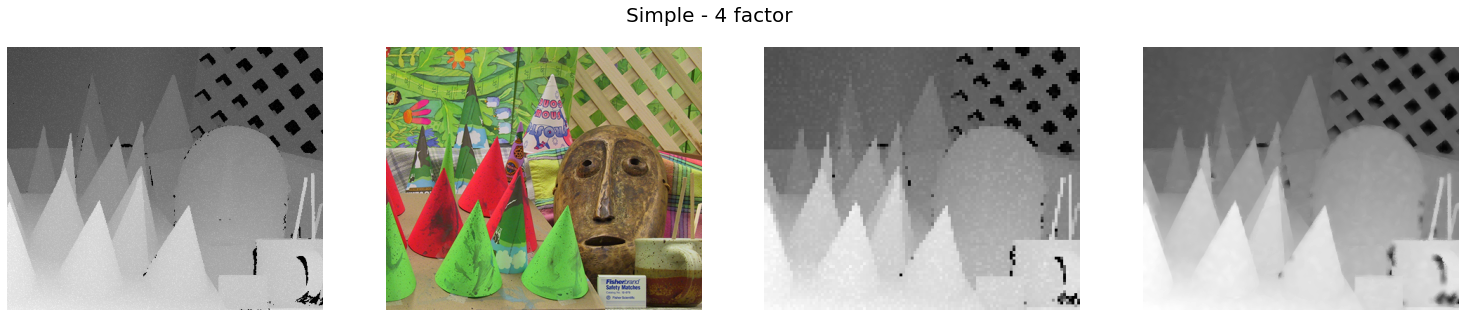

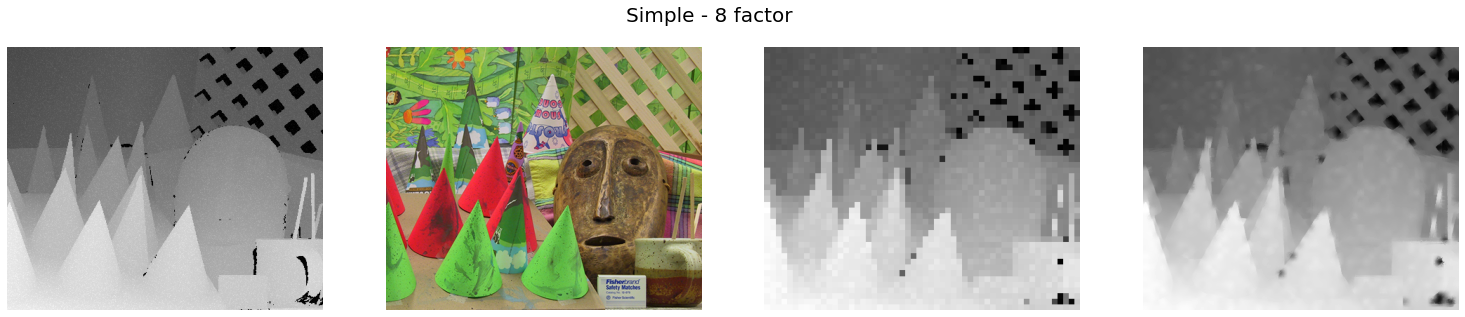

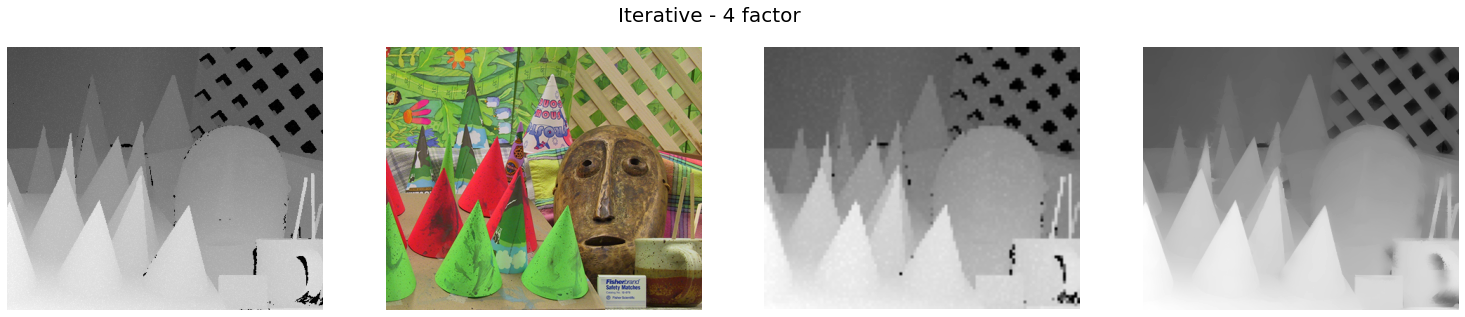

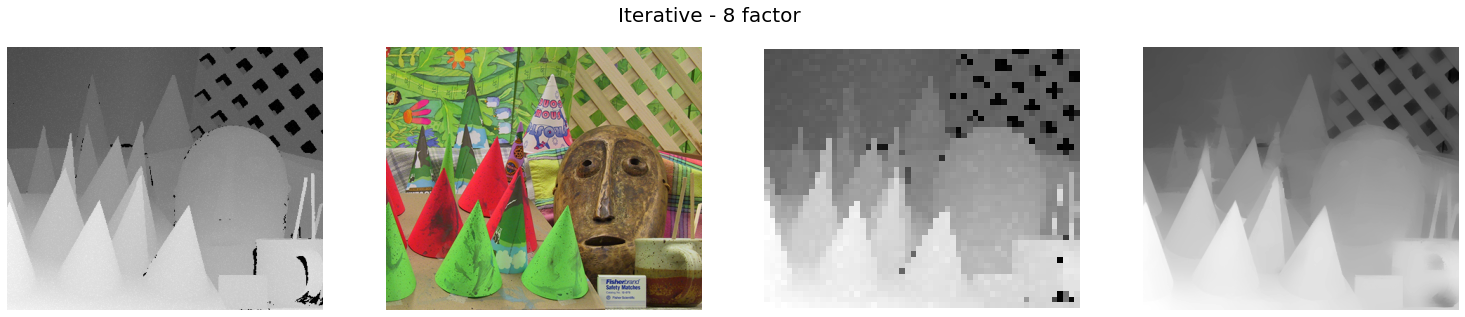

In [11]:
filter_params_simple = dict(window_size=11, sigma_d=6, sigma_r=4)
simple_result_4 = upsample_eval_simple('Cones', 4, filter_params)
simple_result_8 = upsample_eval_simple('Cones', 8, filter_params)

filter_params = dict(window_size=11, sigma_d=4, sigma_r=3)
iter_result_4 = upsample_eval_iterative('Cones', 4, filter_params)
iter_result_8 = upsample_eval_iterative('Cones', 8, filter_params)

plot_images(simple_result_4, 1, 4, title='Simple - 4 factor')
plot_images(simple_result_8, 1, 4, title='Simple - 8 factor')
plot_images(iter_result_4, 1, 4, title='Iterative - 4 factor')
plot_images(iter_result_8, 1, 4, title='Iterative - 8 factor')

#### Comparison with other techniques

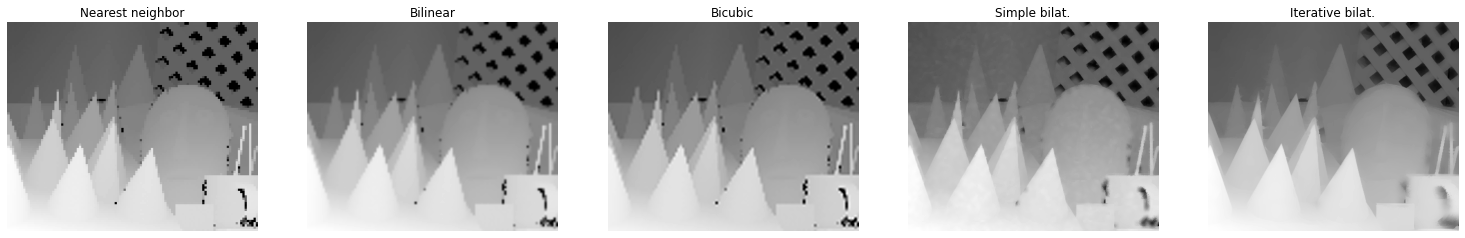

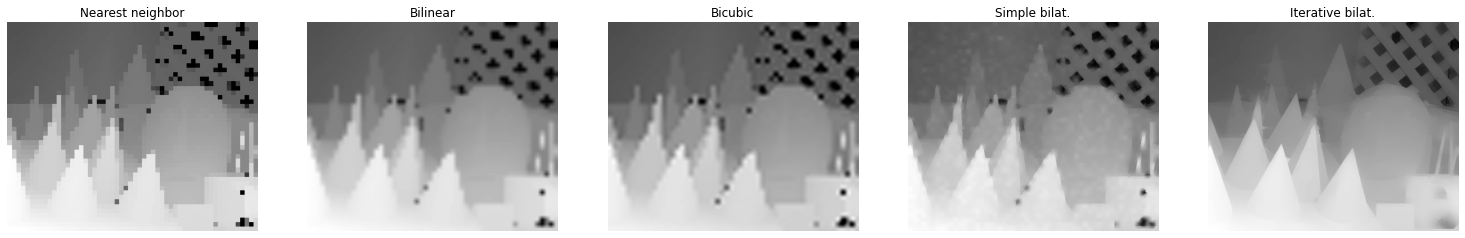

In [12]:
other_techs_4 = get_resized_images('Cones', 4)
other_techs_8 = get_resized_images('Cones', 8)
comparison_4 = other_techs_4 + [simple_result_4[-1], iter_result_4[-1]]
comparison_8 = other_techs_8 + [simple_result_8[-1], iter_result_8[-1]]

plot_images(comparison_4, 1, 5, figsize=(26, 8), labels=['Nearest neighbor', 'Bilinear', 'Bicubic', 'Simple bilat.', 'Iterative bilat.'])
plot_images(comparison_8, 1, 5, figsize=(26, 8), labels=['Nearest neighbor', 'Bilinear', 'Bicubic', 'Simple bilat.', 'Iterative bilat.'])

#### Qualitative comparison

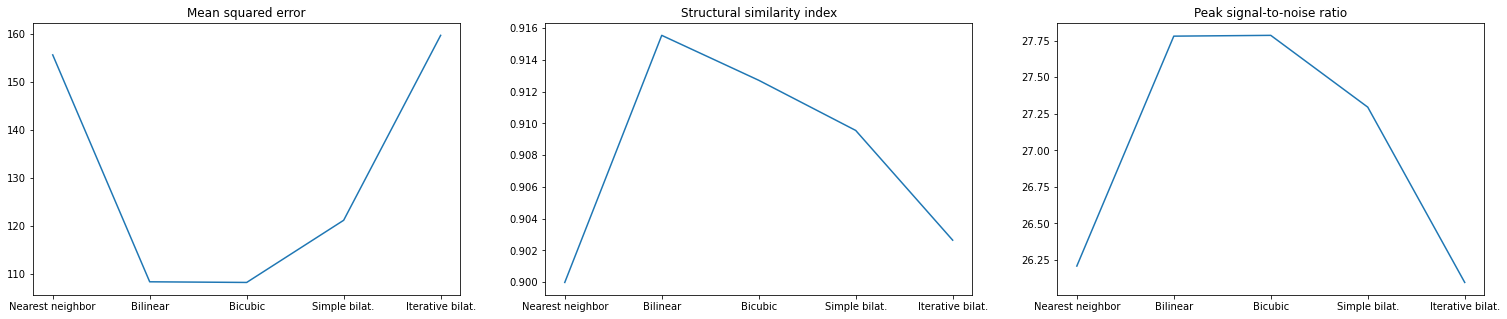

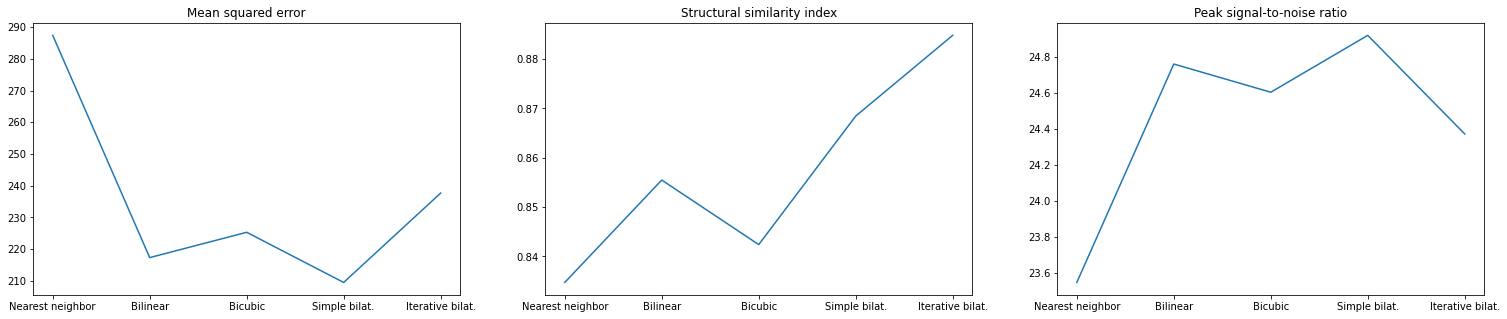

In [13]:
dataset = 'Cones'
gt = cv2.imread(f'datasets/{dataset}/disp.png', cv2.IMREAD_GRAYSCALE)

data_MSE_4=[MSE(comparison_4[0],gt), MSE(comparison_4[1],gt), MSE(comparison_4[2],gt), MSE(comparison_4[3],gt), MSE(comparison_4[4],gt)]
data_MSE_8=[MSE(comparison_8[0],gt), MSE(comparison_8[1],gt), MSE(comparison_8[2],gt), MSE(comparison_8[3],gt), MSE(comparison_8[4],gt)]

data_SSIM_4=[SSIM(comparison_4[0],gt), SSIM(comparison_4[1],gt), SSIM(comparison_4[2],gt), SSIM(comparison_4[3],gt), SSIM(comparison_4[4],gt)]
data_SSIM_8=[SSIM(comparison_8[0],gt), SSIM(comparison_8[1],gt), SSIM(comparison_8[2],gt), SSIM(comparison_8[3],gt), SSIM(comparison_8[4],gt)]

data_PSNR_4=[cv2.PSNR(comparison_4[0], gt),cv2.PSNR(comparison_4[1], gt),cv2.PSNR(comparison_4[2], gt),cv2.PSNR(comparison_4[3], gt),cv2.PSNR(comparison_4[4], gt)]
data_PSNR_8=[cv2.PSNR(comparison_8[0], gt),cv2.PSNR(comparison_8[1], gt),cv2.PSNR(comparison_8[2], gt), cv2.PSNR(comparison_8[3], gt),cv2.PSNR(comparison_8[4], gt)]

plot_metrics([data_MSE_4, data_SSIM_4, data_PSNR_4])
plot_metrics([data_MSE_8, data_SSIM_8, data_PSNR_8])